<a href="https://colab.research.google.com/github/Ismail-therap/NLP-Project-Predicting-review-in-1-to-5-star-/blob/main/Additional_analysis_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
import pandas as pd

url='https://drive.google.com/file/d/1-vBpWV0H0cxX5jSeHlQIKXIiosMKwq2t/view?usp=sharing'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
data = pd.read_csv(dwn_url)

In [62]:
review_by_state = data[['state','text']].groupby('state').count()
review_by_state = pd.DataFrame(review_by_state)
review_by_state.reset_index(inplace=True)
review_by_state=review_by_state.rename(columns = {'state':'STUSPS','text':"Number of reviews"})


# Map of the randomly selected reviews from the Yelp data

In [63]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
#!pip install contextily
import contextily as ctx 
#!pip install geopandas
import geopandas as gpd 
import os 
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [64]:
path = "/content/tl_2021_us_state.shp" 
df = gpd.read_file(path)
df = df.to_crs("EPSG:4326")

In [65]:
mapping_data = pd.merge(df,review_by_state, on="STUSPS",how = 'left')
mapping_data['Number of reviews'] = mapping_data['Number of reviews'].fillna(0)
non_continental = ['HI','VI','MP','GU','AK','AS','PR']
us49 = mapping_data
for n in non_continental:
    us49 = us49[us49.STUSPS != n]

In [69]:
def StatesPlot(df,data, cmap):
    f,ax = plt.subplots(1,1, figsize=(15,10), 
    sharex=True, sharey=True, dpi=300)
    f.tight_layout()
    plt.title('United States Map - Variable = ' + data)
    ax.set_axis_off()
    df.apply(lambda x: ax.annotate(s=x.STUSPS, xy=x.geometry.centroid.coords[0], ha='center', fontsize=14),axis=1);
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", 
    pad=0.5,alpha=0.5)
    df.plot(data, ax=ax, alpha=0.5, cmap=cmap, 
    edgecolor='k', legend=True, cax=cax, linewidth=0.1)
    plt.ylabel('Number of Yelp reviews', fontsize=12)
    plt.show()

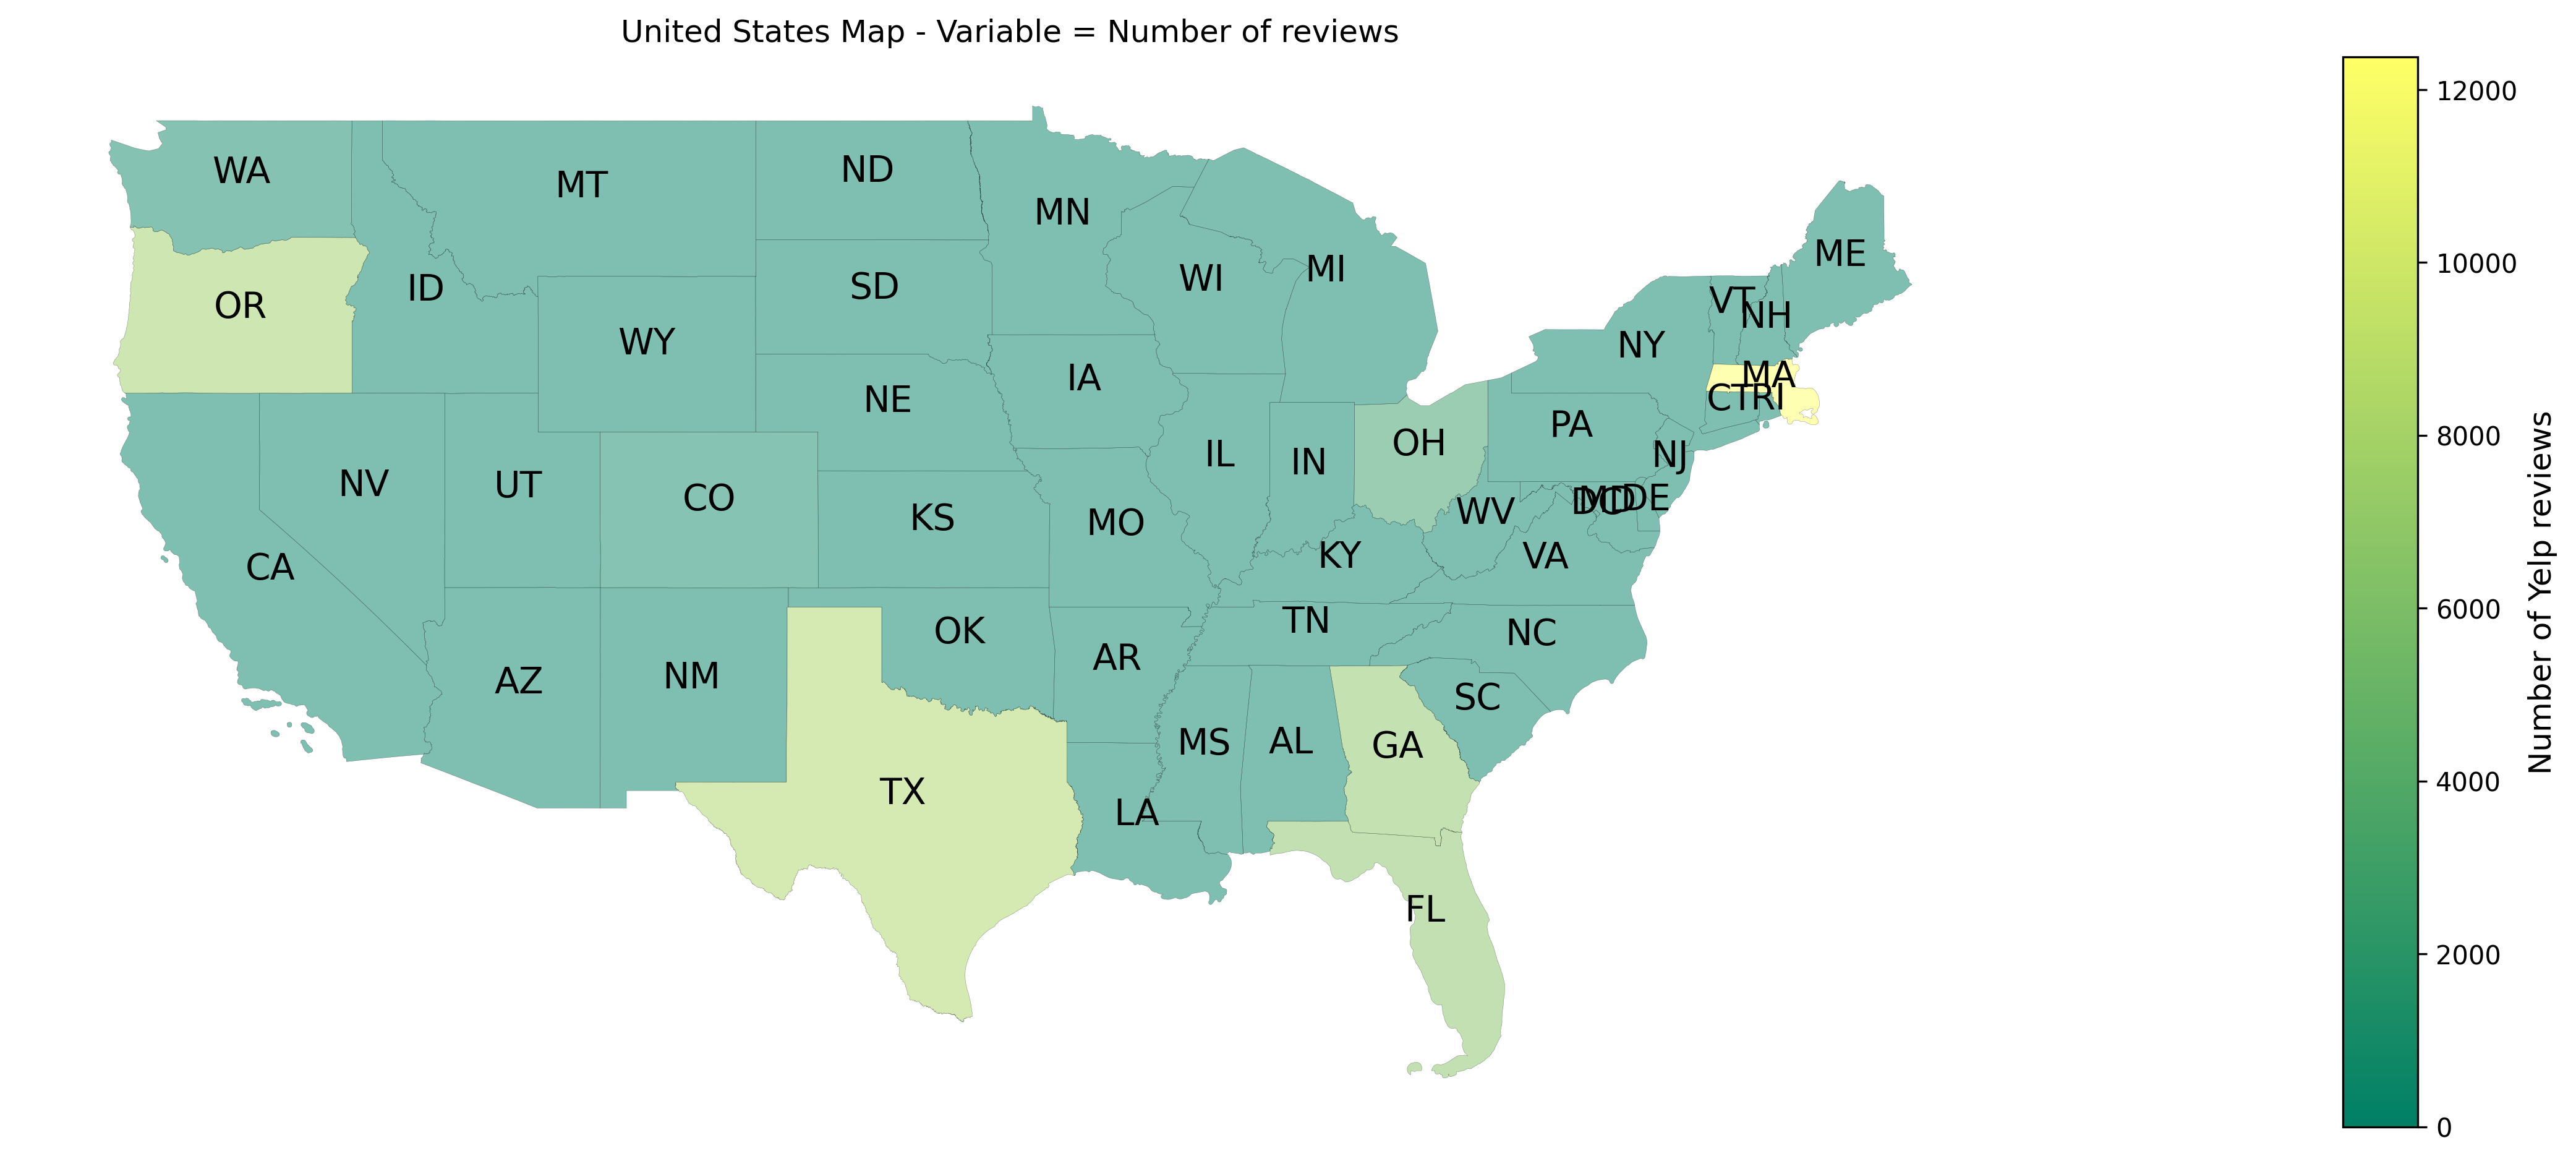

In [70]:
StatesPlot(us49,'Number of reviews', 'summer')

# Reviews by industry

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
#!pip install -c conda-forge basemap-data-hires
#from mpl_toolkits.basemap import Basemap

from wordcloud import WordCloud
#!pip install squarify
import squarify
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import string
import re 
import gensim 
from gensim import corpora

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.style.use('bmh')

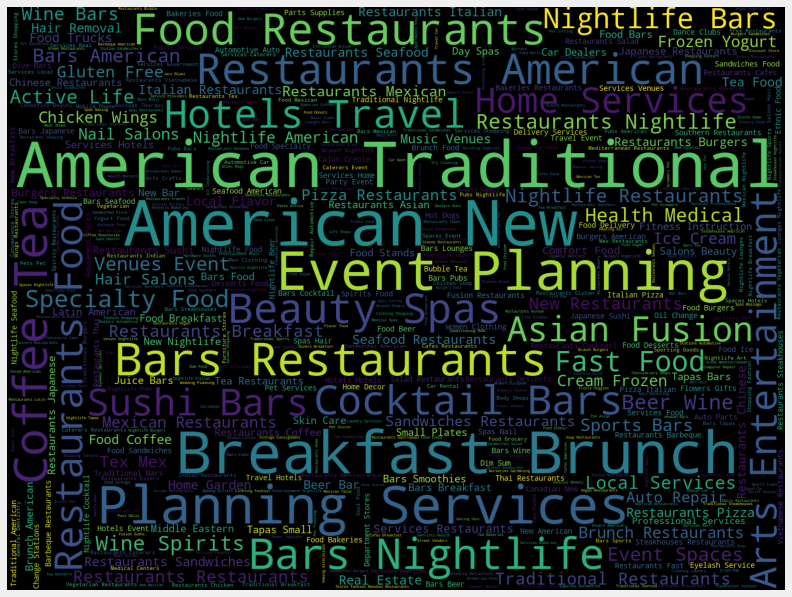

In [83]:
cloud = WordCloud(width=1440, height= 1080,max_words= 500).generate(' '.join(data['categories'].astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off');

In [71]:
data.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,user_id,review_stars,text,date
0,0tGuFBrhM03I6TCLxDQhyg,Dancing Goats Coffee Bar,419 W Ponce De Leon Ave,Decatur,GA,30030,33.775805,-84.303269,4.0,358,1,"{'RestaurantsPriceRange2': '1', 'WiFi': ""'free...","Food, Coffee & Tea, Restaurants, Donuts, Cafes","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",IqUD0yoRq66PqnbSvRb5JA,1,OMG!! Hate! This place. Rude to me. On so many...,2018-10-06 14:34:51
1,498F3rnpng6qv53S9diTSw,Boston Market,"4607 Braker Ln, Ste 100",Austin,TX,78759,30.399832,-97.744997,3.0,102,1,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...","American (Traditional), Caterers, Chicken Shop...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",n2eAlOnBo1St1p7MWqBFmg,1,Why bother being open on Thanksgiving if you c...,2019-11-28 20:02:11
2,7qBi3FMT2Oz4Jj1hCWwawA,Bea's Nail Salon,75 Blossom Ct,Boston,MA,02114,42.364891,-71.066818,3.0,23,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Nail Salons, Beauty & Spas","{'Monday': '9:30-19:0', 'Tuesday': '9:30-19:0'...",pHTrbVN4lzTlzqqnWEJYGw,1,"The fact that on a Saturday afternoon this ""sa...",2009-07-11 19:59:46


# 10 most common word in the review:



In [94]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline


# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words in the review')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


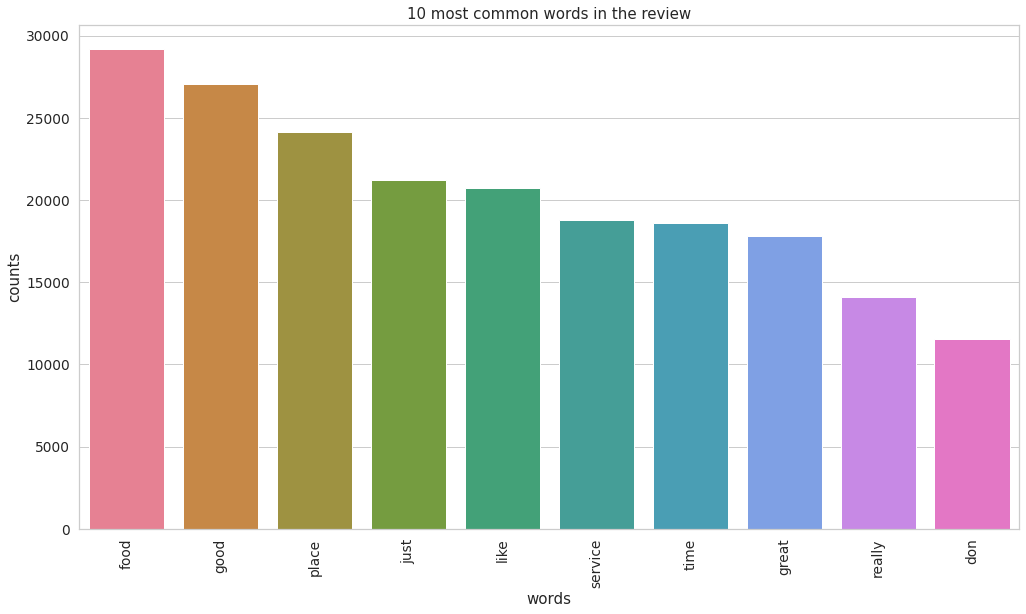

In [95]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(data['text'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

# Topic Modelling

In [96]:
######################################################
#### Topic Modelling on Corona data #################
######################################################


# Run in terminal or command prompt
# python3 -m spacy download en (After opening terminal as an admin)

import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
!pip install pyLDAvis 
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

     |████████████████████████████████| 1.7 MB 4.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=123cd470f0a2d714e54f610564fec4f356d0e7141d405f9f63e98e70cb944fd9
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [97]:
data['text']=data['text'].apply(str)
# Convert to list
data = data.text.values.tolist()

In [98]:
# Data Cleaning and pre-processing

# Remove Emails
data = [re.sub(r'\S*@\S*\s?', '', sent) for sent in data]
# Remove new line characters
data = [re.sub(r'\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data = [re.sub(r"\'", "", sent) for sent in data]


# Removing some generic word from list
data = [re.sub('case', '', sent) for sent in data]
data = [re.sub('confirm', '', sent) for sent in data]
data = [re.sub('announce', '', sent) for sent in data]


# Tokenize

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))
print(data_words[:1])


# Stemming


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out


# Initialize spacy ‘en’ model, keeping only tagger component (for efficiency)
# Run in terminal: python -m spacy download en

nlp = spacy.load('en', disable=['parser', 'ner'])
# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'VERB']) #select noun and verb
print(data_lemmatized[:2])


# Initialise the count vectorizer with the English stop words
#count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
#count_data = count_vectorizer.fit_transform(review['paper_text_processed'][1:1000])


vectorizer = CountVectorizer(analyzer='word',       
                             min_df=5,
# minimum reqd occurences of a word 
                             stop_words='english',             
# remove stop words
                             lowercase=True,                   
# convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  
# num chars > 3
                             # max_features=50000,             
# max number of uniq words    
                            )
data_vectorized = vectorizer.fit_transform(data_lemmatized)

[['omg', 'hate', 'this', 'place', 'rude', 'to', 'me', 'on', 'so', 'many', 'levels', 'im', 'allergic', 'to', 'milk', 'your', 'called', 'the', 'dancing', 'goat', 'for', 'gods', 'sake', 'thought', 'you', 'might', 'have', 'goats', 'milk', 'no', 'didnt', 'ask', 'that', 'asked', 'if', 'they', 'had', 'anything', 'other', 'then', 'milk', 'they', 'said', 'soy', 'milk', 'and', 'almond', 'milk', 'extra', 'rude', 'then', 'asked', 'about', 'the', 'scones', 'another', 'rude', 'response', 'then', 'ordered', 'blowing', 'off', 'heard', 'them', 'be', 'extremely', 'positive', 'when', 'the', 'next', 'lady', 'asks', 'the', 'same', 'exact', 'question', 'about', 'the', 'scones', 'and', 'will', 'post', 'picture', 'of', 'my', 'coffee', 'verse', 'my', 'husband', 'coffee', 'no', 'heart', 'for', 'me', 'dont', 'know', 'what', 'it', 'was', 'about', 'me', 'im', 'black', 'what', 'but', 'they', 'didnt', 'like', 'me', 'and', 'they', 'were', 'mean', 'table', 'were', 'gross', 'scone', 'was', 'awful', 'never', 'going', 'b

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: Sele

['hate place level be allergic milk call dancing goat god sake think may goat milk ask ask milk say soy milk almond milk rude ask scone response order blow hear lady ask question scone will post picture coffee verse husband coffee heart know be black like table scone go should stink', 'bother thanksgiving can fulfill order place order pay advance pickup window arrive minute line door wait minute line verify pre order pre pay order follow minute food could make scratch point one could give answer need wait file dispute credit card company take hour suppose take minute']


In [99]:
# Define Search Param
search_params = {'n_components': [3,5,10], 'learning_decay': [0.05,0.1,0.2,.3, .7, .9]}
# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(learning_method='online',
                                                 learning_offset=50.0,
                                                 max_iter=5, random_state=0),
             param_grid={'learning_decay': [0.05, 0.1, 0.2, 0.3, 0.7, 0.9],
                         'n_components': [3, 5, 10]})

In [100]:
# Best Model
best_lda_model = model.best_estimator_
# Model Parameters
print("Best Model's Params: ", model.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 3}
Best Log Likelihood Score:  -2384042.707626756
Model Perplexity:  998.6835235504705


In [101]:
Number_of_topic = 3

# Create Document — Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)
# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]
# index names
docnames = ["Case" + str(i) for i in range(len(data))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output,Number_of_topic), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
# Styling
def color_green(val):
 color = 'green' if val > .1 else 'black'
 return 'color: {col}'.format(col=color)
def make_bold(val):
 weight = 700 if val > .1 else 400
 return 'font-weight: {weight}'.format(weight=weight)
# Apply Style
df_document_topics = df_document_topic.head(50).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,dominant_topic
Case0,0.222000,0.242000,0.536000,2
Case1,0.194000,0.797000,0.009000,1
Case2,0.009000,0.068000,0.924000,2
Case3,0.827000,0.007000,0.166000,0
Case4,0.342000,0.647000,0.010000,1
Case5,0.420000,0.278000,0.302000,0
Case6,0.021000,0.958000,0.021000,1
Case7,0.059000,0.882000,0.059000,1
Case8,0.066000,0.920000,0.014000,1
Case9,0.014000,0.810000,0.175000,1


In [102]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)
# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames
# View
df_topic_keywords.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aaa,abandon,abide,ability,abomination,abound,absence,absolute,absorb,abundance,...,zillion,zing,zip,zipper,zoe,zombie,zone,zoo,zoom,zucchini
Topic0,0.333615,0.558959,0.458967,0.409210,1.999691,1.125664,11.696412,4.788034,11.525523,15.889695,...,0.560583,16.083471,1.700303,0.333386,13.191936,0.399188,0.434285,0.345757,0.378437,103.627420
Topic1,10.443914,17.883167,4.111854,60.681264,1.327281,0.351408,1.603169,3.748312,0.447548,0.360593,...,2.609375,0.339975,28.733861,7.318102,0.369180,0.389752,23.865747,0.352929,0.396903,0.339443
Topic2,0.339340,10.320657,10.316631,25.366901,0.734223,9.159398,3.364335,14.571444,15.306886,28.140073,...,4.295175,6.122432,8.814658,0.342653,0.348149,23.673114,86.017572,71.436643,15.457866,0.362234


In [103]:
# Show top n keywords for each topic
def show_topics(vectorizer,lda_model,n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [104]:
topic_keywords = show_topics(vectorizer=vectorizer, lda_model = best_lda_model, n_words=5)
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 0,Word 1,Word 2,Word 3,Word 4
Topic 0,food,order,place,come,service
Topic 1,time,service,say,work,make
Topic 2,place,love,pizza,make,time


In [105]:
Topics = [df_topic_keywords.iloc[0].tolist(),
          df_topic_keywords.iloc[1].tolist(),
         df_topic_keywords.iloc[2].tolist()]
df_topic_keywords["Topics"]=Topics
#df_topic_keywords["Topics_category"] = ["Call Benificiary","Plan Receive","State Issue"]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Topics
Topic 0,food,order,place,come,service,"[food, order, place, come, service]"
Topic 1,time,service,say,work,make,"[time, service, say, work, make]"
Topic 2,place,love,pizza,make,time,"[place, love, pizza, make, time]"


In [106]:
################################################################
############### Predict Topics using LDA model #################
################################################################



# Define function to predict topic for a given text document.
nlp = spacy.load('en', disable=['parser', 'ner'])
def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization
# Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))
# Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)
# Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), 1:14].values.tolist()
    
    # Step 5: Infer Topic
    infer_topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), -1]
    
    #topic_guess = df_topic_keywords.iloc[np.argmax(topic_probability_scores), Topics]
    return infer_topic, topic, topic_probability_scores
# Predict the topic
mytext = ["Very Useful in diabetes age 30. I need control sugar. thanks Good deal"]
infer_topic, topic, prob_scores = predict_topic(text = mytext)
print(topic)
print(infer_topic)

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


['love', 'pizza', 'make', 'time', ['place', 'love', 'pizza', 'make', 'time']]
['place', 'love', 'pizza', 'make', 'time']


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [107]:
def apply_predict_topic(text):
 text = [text]
 infer_topic, topic, prob_scores = predict_topic(text = text)
 return(infer_topic)

In [111]:
import pandas as pd

url='https://drive.google.com/file/d/1-vBpWV0H0cxX5jSeHlQIKXIiosMKwq2t/view?usp=sharing'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
data = pd.read_csv(dwn_url)


data['Processed Notes'] = data['text'].apply(str).apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)",' ',x).split()))
data["Topic_key_word"]= data['Processed Notes'].apply(apply_predict_topic)
data.head()

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: Sele

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,user_id,review_stars,text,date,Processed Notes,Topic_key_word
0,0tGuFBrhM03I6TCLxDQhyg,Dancing Goats Coffee Bar,419 W Ponce De Leon Ave,Decatur,GA,30030,33.775805,-84.303269,4.0,358,1,"{'RestaurantsPriceRange2': '1', 'WiFi': ""'free...","Food, Coffee & Tea, Restaurants, Donuts, Cafes","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",IqUD0yoRq66PqnbSvRb5JA,1,OMG!! Hate! This place. Rude to me. On so many...,2018-10-06 14:34:51,OMG Hate This place Rude to me On so many leve...,"[place, love, pizza, make, time]"
1,498F3rnpng6qv53S9diTSw,Boston Market,"4607 Braker Ln, Ste 100",Austin,TX,78759,30.399832,-97.744997,3.0,102,1,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...","American (Traditional), Caterers, Chicken Shop...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",n2eAlOnBo1St1p7MWqBFmg,1,Why bother being open on Thanksgiving if you c...,2019-11-28 20:02:11,Why bother being open on Thanksgiving if you c...,"[time, service, say, work, make]"
2,7qBi3FMT2Oz4Jj1hCWwawA,Bea's Nail Salon,75 Blossom Ct,Boston,MA,02114,42.364891,-71.066818,3.0,23,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Nail Salons, Beauty & Spas","{'Monday': '9:30-19:0', 'Tuesday': '9:30-19:0'...",pHTrbVN4lzTlzqqnWEJYGw,1,"The fact that on a Saturday afternoon this ""sa...",2009-07-11 19:59:46,The fact that on a Saturday afternoon this sal...,"[place, love, pizza, make, time]"
3,K4X4nJVp0BcSn9Cvoavk8A,T'Kilas Tacos & More,1248 Clairmont Rd,Decatur,GA,30030,33.789815,-84.307511,3.0,115,0,"{'GoodForKids': 'True', 'BikeParking': 'False'...","Mexican, Restaurants","{'Monday': '11:0-22:30', 'Tuesday': '11:0-22:3...",Jfc8qYR3uEHIpU0nKzpObg,1,"I came to Los Loros in search of the ""strong, ...",2008-09-08 21:34:50,I came to Los Loros in search of the strong CH...,"[food, order, place, come, service]"
4,D6U1_06gxciRs1NoYjwhKQ,ESPN Club - Temporarily Unavailable,2101 N Epcot Resorts Blvd,Orlando,FL,32836,28.368008,-81.555289,2.5,303,1,"{'GoodForKids': 'True', 'Caters': 'False', 'Re...","Hotels, American (New), Event Planning & Servi...","{'Monday': '0:0-0:0', 'Tuesday': '12:0-23:0', ...",Dw_oka5MVWOsaJCncfIXZQ,1,My fries were stale and my cheesesteak was mos...,2018-01-14 01:41:50,My fries were stale and my cheesesteak was mos...,"[time, service, say, work, make]"
